# Exploratory Data Analysis


In [1]:
# Imports
import os
import pylidc as pl
from pylidc.utils import consensus
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as manim
from skimage.measure import find_contours

from lcd.eda.patient import Patient

In [2]:
# Constants
LIDC_FILEPATH = "data/0_external/LIDC-IDRI"

# Patients

In [3]:
n_patients = len(os.listdir(LIDC_FILEPATH))
print("There are {} patients in the LIDC-IDRI dataset".format(str(n_patients)))

There are 1011 patients in the LIDC-IDRI dataset


## Scans

In [4]:
scans = pl.query(pl.Scan)
print("There are {} scans in the LIDC-IDRI dataset".format(scans.count()))

There are 1018 scans in the LIDC-IDRI dataset


### Nodules

In [5]:
# nodules = scan.cluster_annotations()
# print("Patient {} has {} nodules.".format(pid, len(nodules)))

NameError: name 'scan' is not defined

Loading dicom files ... This may take a moment.


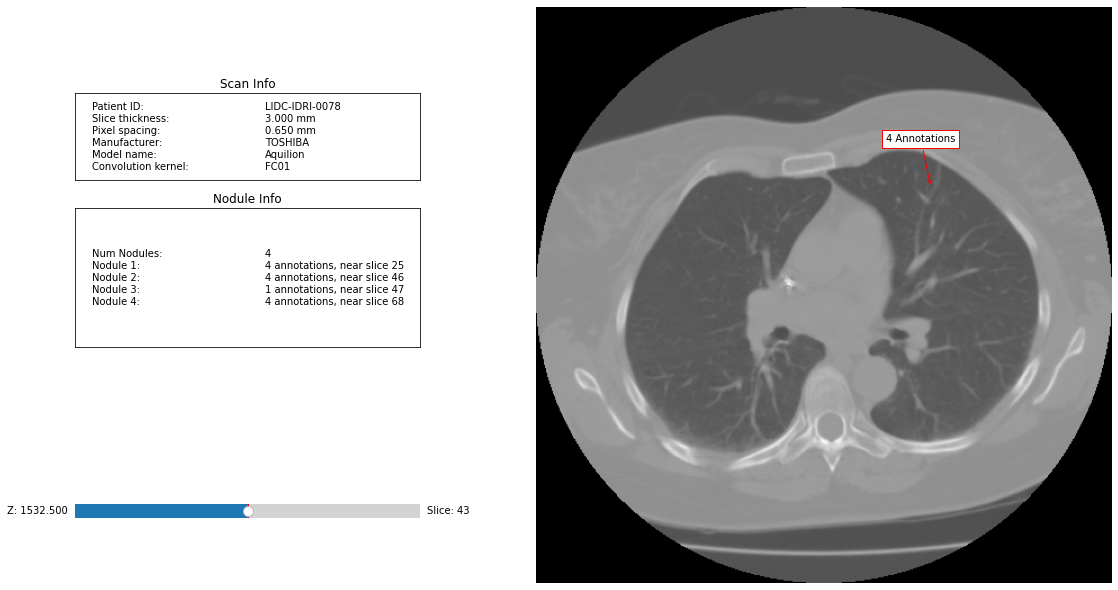

In [6]:
# pid = 'LIDC-IDRI-0078'
# scan = pl.query(pl.Scan).filter(pl.Scan.patient_id == pid).first()
# scan.visualize(annotation_groups=nodules)

scan = pl.query(pl.Scan).first()
nodules = scan.cluster_annotations()

scan.visualize(annotation_groups=nodules)

Loading dicom files ... This may take a moment.
Patient LIDC-IDRI-0078 has 87 images
3.0 3.0


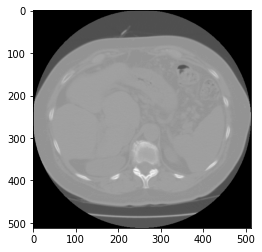

In [21]:
images = scan.load_all_dicom_images()
print("Patient {} has {} images".format(pid, str(len(images))))
zs = [float(img.ImagePositionPatient[2]) for img in images]
print(zs[1] - zs[0], scan.slice_thickness)

plt.imshow( images[0].pixel_array, cmap=plt.cm.gray )
plt.show()

## Annotations

Loading dicom files ... This may take a moment.


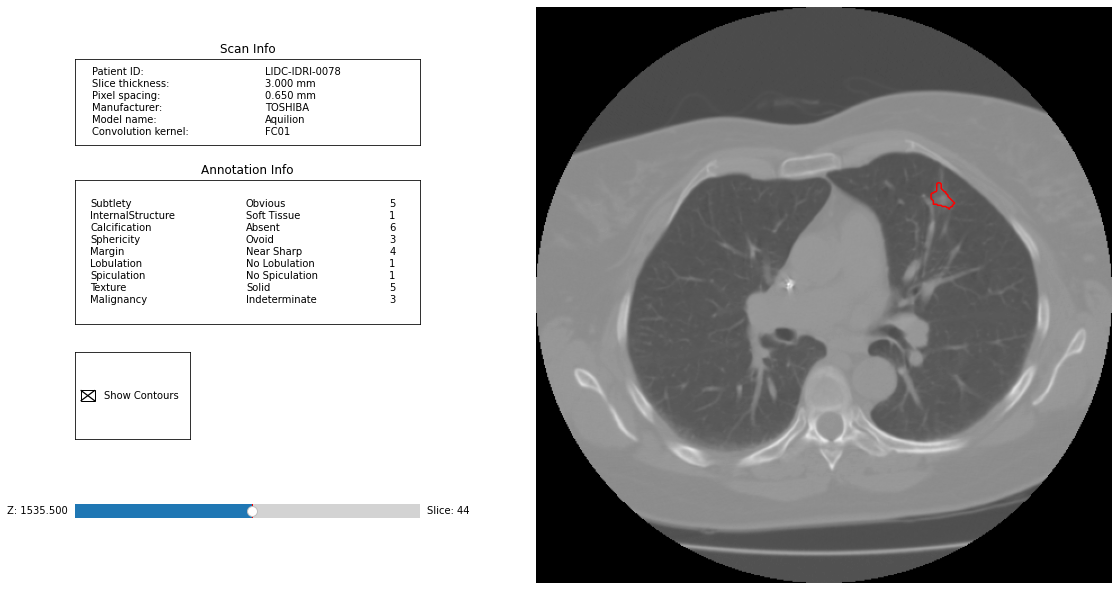

In [7]:
ann = pl.query(pl.Annotation).first()
ann.visualize_in_scan()

Loading dicom files ... This may take a moment.


(-0.5, 61.5, 73.5, -0.5)

(-0.5, 61.5, 73.5, -0.5)

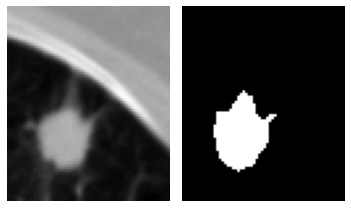

In [9]:
ann = pl.query(pl.Annotation).first()
vol = ann.scan.to_volume()

padding = [(30,10), (10,25), (0,0)]

mask = ann.boolean_mask(pad=padding)
bbox = ann.bbox(pad=padding)

fig,ax = plt.subplots(1,2,figsize=(5,3))

ax[0].imshow(vol[bbox][:,:,2], cmap=plt.cm.gray)
ax[0].axis('off')

ax[1].imshow(mask[:,:,2], cmap=plt.cm.gray)
ax[1].axis('off')

plt.tight_layout()
#plt.savefig("../images/mask_bbox.png", bbox_inches="tight")
plt.show()

Loading dicom files ... This may take a moment.


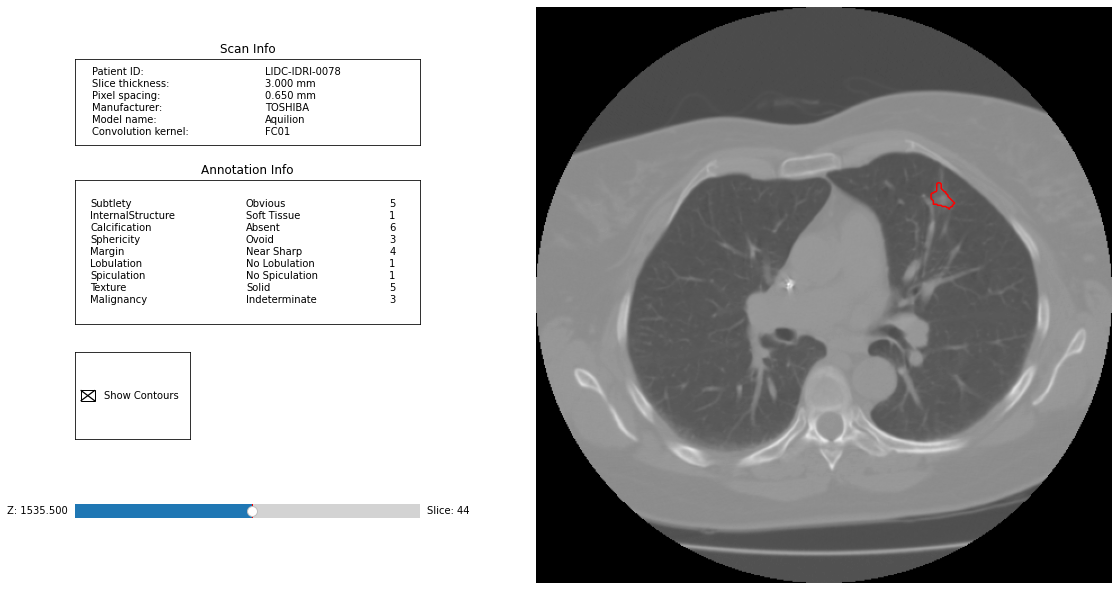

In [11]:
ann = pl.query(pl.Annotation).first()
ann.visualize_in_scan()

## Annotation Consensus

Loading dicom files ... This may take a moment.


(-0.5, 83.5, 73.5, -0.5)

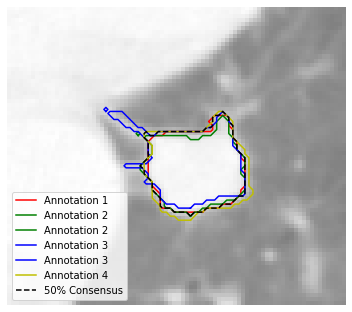

In [2]:
# Query for a scan, and convert it to an array volume.
scan = pl.query(pl.Scan).filter(pl.Scan.patient_id == 'LIDC-IDRI-0078').first()
vol = scan.to_volume()

# Cluster the annotations for the scan, and grab one.
nods = scan.cluster_annotations()
anns = nods[0]

# Perform a consensus consolidation and 50% agreement level.
# We pad the slices to add context for viewing.
cmask,cbbox,masks = consensus(anns, clevel=0.5,
                              pad=[(20,20), (20,20), (0,0)])

# Get the central slice of the computed bounding box.
k = int(0.5*(cbbox[2].stop - cbbox[2].start))

# Set up the plot.
fig,ax = plt.subplots(1,1,figsize=(5,5))
ax.imshow(vol[cbbox][:,:,k], cmap=plt.cm.gray, alpha=0.5)

# Plot the annotation contours for the kth slice.
colors = ['r', 'g', 'b', 'y']
for j in range(len(masks)):
    for c in find_contours(masks[j][:,:,k].astype(float), 0.5):
        label = "Annotation %d" % (j+1)
        plt.plot(c[:,1], c[:,0], colors[j], label=label)

# Plot the 50% consensus contour for the kth slice.
for c in find_contours(cmask[:,:,k].astype(float), 0.5):
    plt.plot(c[:,1], c[:,0], '--k', label='50% Consensus')

ax.axis('off')
ax.legend()
plt.tight_layout()
#plt.savefig("../images/consensus.png", bbox_inches="tight")
plt.show()